In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import datawig

In [2]:
df = pd.read_csv('./data/galaxy.csv')

In [3]:
df.head()

,BuyItNow,startprice,carrier,color,productline,noDescription,charCountDescription,upperCaseDescription,sold
0,0,199.99,None,White,Galaxy_S9,contains description,0,0,1
1,0,235.00,None,NaN,Galaxy_Note9,contains description,0,0,0
2,0,199.99,NaN,NaN,Unknown,no description,100,2,0
3,1,175.00,AT&T,Space Gray,Galaxy_Note9,contains description,0,0,1
4,1,100.00,None,Space Gray,Galaxy_S8,contains description,0,0,1


In [7]:
df.isnull().sum() / len(df)

BuyItNow                0.000000
startprice              0.000000
carrier                 0.206061
color                   0.399327
productline             0.000000
noDescription           0.000000
charCountDescription    0.000000
upperCaseDescription    0.000000
sold                    0.000000
dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 9 columns):
BuyItNow                1485 non-null int64
startprice              1485 non-null float64
carrier                 1179 non-null object
color                   892 non-null object
productline             1485 non-null object
noDescription           1485 non-null object
charCountDescription    1485 non-null int64
upperCaseDescription    1485 non-null int64
sold                    1485 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 104.5+ KB


In [8]:
df.describe()

,BuyItNow,startprice,charCountDescription,upperCaseDescription,sold
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,0.449158,216.844162,31.184512,2.863300,0.461953
std,0.497576,172.893308,41.744518,9.418585,0.498718
min,0.000000,0.010000,0.000000,0.000000,0.000000
25%,0.000000,80.000000,0.000000,0.000000,0.000000
50%,0.000000,198.000000,0.000000,0.000000,0.000000
75%,1.000000,310.000000,79.000000,2.000000,1.000000
max,1.000000,999.000000,111.000000,81.000000,1.000000


# Simple EDA

<AxesSubplot:>

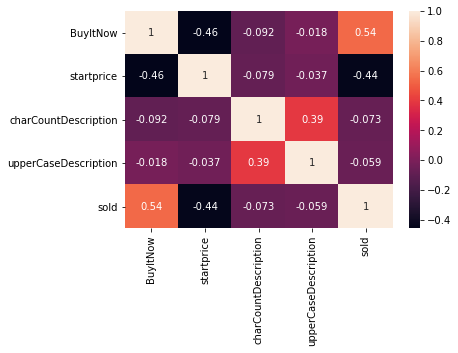

In [13]:
# heatmap for correlation
# BuyItNow - sold 0.54 높은 상관성
# startprice - sold -0.44 높은 상관성
# BuyItNow - startprice -0.46 높은 상관성
# charCountDescription - upperCaseDescription 높은 상관성
sns.heatmap(df.corr(), annot=True)

### 핵심 컬럼 = BuyItNow & startprice, 결측값과의 관계는?
- `carrier`
- `color`

> 유의미한 상관관계 및 label 설명력이 존재함을 확인

In [21]:
# carrier - startprice
df.groupby('carrier')['startprice'].mean().sort_values(ascending=False)

carrier
Sprint/T-Mobile    307.216538
Verizon            234.781724
AT&T               209.773446
None               207.885307
Name: startprice, dtype: float64

In [20]:
# carrier - sold
df.groupby('carrier')['sold'].sum().sort_values(ascending=False)

carrier
None               416
AT&T                76
Verizon             46
Sprint/T-Mobile     24
Name: sold, dtype: int64

In [19]:
# color - startprice
df.groupby('color')['startprice'].mean().sort_values(ascending=False)

color
Gold              443.593846
Aura Black        319.457368
Prism Black       299.000000
Space Gray        276.767389
White             242.726768
Black             159.865263
Midnight Black    145.545000
Name: startprice, dtype: float64

In [23]:
# color sold
df.groupby('color')['sold'].sum().sort_values(ascending=False)

color
Midnight Black    153
White             143
Space Gray         81
Gold               18
Black              16
Aura Black          6
Prism Black         0
Name: sold, dtype: int64

# 결측치 분석
https://eda-ai-lab.tistory.com/14


완전 무작위 결측(MCAR : Missing completely at random)
- 변수 상에서 발생한 결측치가 다른 변수들과 아무런 상관이 없는 경우 우리는 완전 무작위 결측(MCAR)이라고 부릅니다. 대부분의 결측치 처리 패키지가 MCAR을 가정으로 하고 있고 보통 우리가 생각하는 결측치라고 생각하시면 됩니다. 예를 들어, 데이터를 입력하는 사람이 깜빡하고 입력을 안했다든지 전산오류로 누락된 경우 등 입니다. 이러한 결측치는 보통 제거하거나 대규모 데이터 셋에서 단순 무작위 표본추출을 통해서 완벽한 데이터셋으로 만들 수 있습니다.
 
무작위 결측(MAR : Missing at random)
- 누락된 자료가 특정 변수와 관련되어 일어나지만, 그 변수의 결과는 관계가 없는 경우를 의미합니다. 그리고 누락이 전체 정보가 있는 변수로 설명이 될 수 있음을 의미합니다.(누락이 완전히 설명 될 수 있는 경우 발생) 예를 들어, 남성은 우울증 설문 조사에 기입 할 확률이 적지만 우울함의 정도와는 상관이 없는 경우입니다.  

비 무작위 결측(MNAR : Missing at not random)
- 위의 두가지 유형이 아닌 경우를 MNAR이라고 합니다. MNAR은 누락된 값(변수의 결과)이 다른 변수와 연관 있는 경우를 의미합니다. 위의 예시를 확장해서, 만약 남성이 우울증 설문 조사에 기입하는게 우울증의 정도와 관련이 있다면 이것은 MNAR입니다. 

In [59]:
len(df)

1485

In [18]:
df['carrier'].value_counts()

None               863
AT&T               177
Verizon             87
Sprint/T-Mobile     52
Name: carrier, dtype: int64

In [17]:
df['color'].value_counts()

White             328
Midnight Black    274
Space Gray        180
Gold               52
Black              38
Aura Black         19
Prism Black         1
Name: color, dtype: int64

### `color` - `carrier` 간 상관성 확인
- 그런 거 없음

Text(0.5, 1.0, 'Correlation with Missing Values')

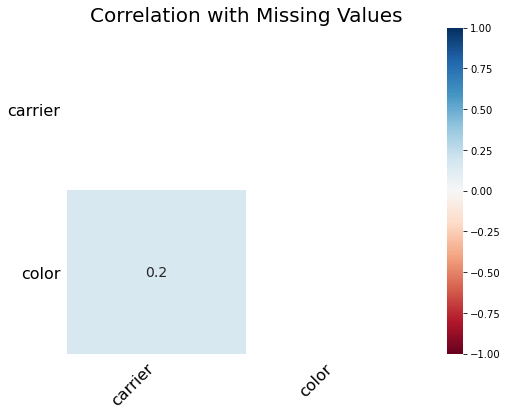

In [24]:
import missingno as msno
missingdata_df = df.columns[df.isnull().any()].tolist()
msno.heatmap(df[missingdata_df], figsize=(8,6))
plt.title("Correlation with Missing Values", fontsize = 20)

### `has_color` & `has_carrier` 컬럼 생성
- `has_color`
    - color 변수값이 결측치면 0, 정상값이면 1
- `has_carrier`
    - carrier 변수값이 결측치면 0, 정상값이면 1


In [26]:
df_cp = df.copy()
df_cp['has_color'] = df_cp['color'].apply(lambda x: 1 if type(x) == str else 0)
df_cp['has_carrier'] = df_cp['carrier'].apply(lambda x: 1 if type(x) == str else 0)

In [27]:
# 다른 변수들 간의 상관관계 확인
# 그런 거 없음
df_cp.corr()

,BuyItNow,startprice,charCountDescription,upperCaseDescription,sold,has_color,has_carrier
BuyItNow,1.000000,-0.456724,-0.092170,-0.018091,0.540054,0.025848,0.028258
startprice,-0.456724,1.000000,-0.079081,-0.036946,-0.443617,0.090669,-0.026231
charCountDescription,-0.092170,-0.079081,1.000000,0.394730,-0.073461,-0.023907,0.022520
upperCaseDescription,-0.018091,-0.036946,0.394730,1.000000,-0.058993,0.030220,-0.021189
sold,0.540054,-0.443617,-0.073461,-0.058993,1.000000,0.013619,0.057965
has_color,0.025848,0.090669,-0.023907,0.030220,0.013619,1.000000,0.169309
has_carrier,0.028258,-0.026231,0.022520,-0.021189,0.057965,0.169309,1.000000


### `color`, `carrier` 결측 패턴이 존재하는가?
- 결측 패턴이 존재하는지 확인
- 결측이 발생한 데이터 샘플에 공통적인 특성이 존재하는지 확인
    - 원본 데이터와 비교

In [28]:
# color or carrier 어느 한 쪽만 누락되었음
diffs1 = [(color,carrier) for (color, carrier) in np.array(df_cp[['has_color', 'has_carrier']])\
            if color != carrier]

# color & carrier 모두 누락되었음
diffs2 = [(color,carrier) for (color, carrier) in np.array(df_cp[['has_color', 'has_carrier']])\
            if (color == 0) and (carrier==0)]

# 어느 하나만 누락됨 555개
# 둘 다 누락됨 172개
len(diffs1), len(diffs2)

(555, 172)

In [47]:
df_color_carrier_both_nan = df_cp[(df_cp['has_color']==0) & (df_cp['has_carrier']==0)]
df_color_carrier_both_nan # 172 rows

,BuyItNow,startprice,carrier,color,productline,noDescription,charCountDescription,upperCaseDescription,sold,has_color,has_carrier
2,0,199.99,NaN,NaN,Unknown,no description,100,2,0,0,0
61,0,279.99,NaN,NaN,Galaxy_Note10,no description,86,3,0,0,0
75,0,193.15,NaN,NaN,Unknown,contains description,0,0,0,0,0
108,1,100.00,NaN,NaN,Unknown,no description,33,4,1,0,0
126,0,639.99,NaN,NaN,Galaxy_Note10,contains description,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1455,0,319.00,NaN,NaN,Unknown,no description,97,2,0,0,0
1456,0,289.00,NaN,NaN,Unknown,no description,101,4,0,0,0
1464,0,430.00,NaN,NaN,Galaxy_Note10,contains description,0,0,0,0,0
1465,1,52.25,NaN,NaN,Unknown,contains description,0,0,0,0,0


In [48]:
df_color_carrier_either_nan = df_cp[(df_cp['has_color'] != df_cp['has_carrier'])]
df_color_carrier_either_nan # 555 rows

,BuyItNow,startprice,carrier,color,productline,noDescription,charCountDescription,upperCaseDescription,sold,has_color,has_carrier
1,0,235.00,None,NaN,Galaxy_Note9,contains description,0,0,0,0,1
5,1,0.99,NaN,White,Galaxy_S7,contains description,0,0,1,1,0
18,0,329.99,NaN,Space Gray,Unknown,contains description,0,0,0,1,0
21,0,84.99,AT&T,NaN,Galaxy_S7,no description,16,15,1,0,1
22,0,249.99,None,NaN,Galaxy_S9,no description,101,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1467,0,87.00,None,NaN,Unknown,contains description,0,0,0,0,1
1471,0,329.99,None,NaN,Galaxy_Note9,contains description,0,0,0,0,1
1472,0,36.95,None,NaN,Galaxy_S7,no description,70,10,0,0,1
1478,0,319.00,NaN,White,Unknown,contains description,0,0,0,1,0


### 원본 데이터와 분포 비교해보기
- startprice 등 핵심 변수에 대하여 유의미한 차이를 보이지 않음

> `color` 및 `carrier` 결측치는 일정한 패턴이나 휴먼 에러로 발생하지 않았음

> `color` 및 `carrier` 결측치는 완전 무작위 결측(MCAR : Missing completely at random)으로 판단함

In [77]:
# 원본 / df_color_carrier_both_nan / df_color_carrier_either_nan
# 세 데이터프레임의 특정 numerical feature 분포를 비교하는 함수를 작성.
def show_triple_distplot(df1, df2, df3, colname, labels=['original df', 'both nan', 'either nan']):
    f, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True)
    sns.histplot(df1[colname], color='skyblue', label=labels[0], ax=axes[0])
    sns.histplot(df2[colname], color='red', label=labels[1], ax=axes[1])
    sns.histplot(df3[colname], color='green', label=labels[2], ax=axes[2])

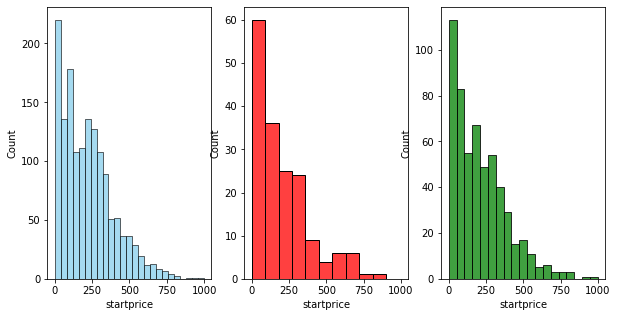

In [78]:
show_triple_distplot(df, df_color_carrier_both_nan, df_color_carrier_either_nan,
                    'startprice')

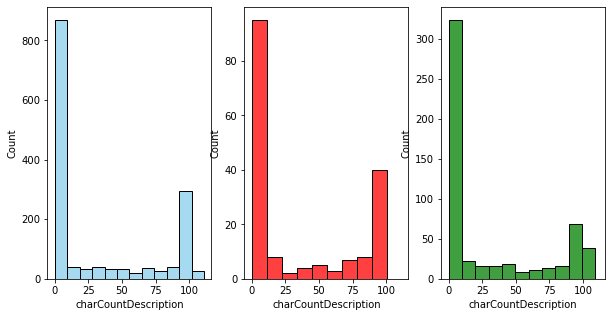

In [79]:
show_triple_distplot(df, df_color_carrier_both_nan, df_color_carrier_either_nan,
                    'charCountDescription')

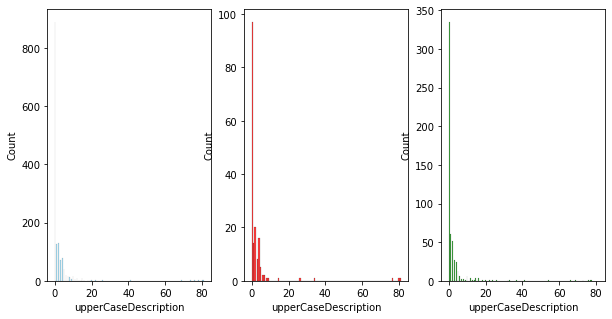

In [80]:
show_triple_distplot(df, df_color_carrier_both_nan, df_color_carrier_either_nan,
                    'upperCaseDescription')

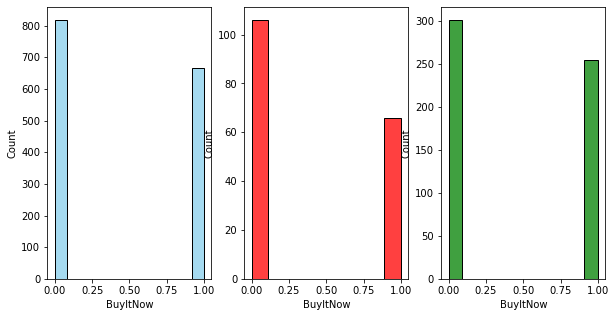

In [81]:
show_triple_distplot(df, df_color_carrier_both_nan, df_color_carrier_either_nan,
                    'BuyItNow')

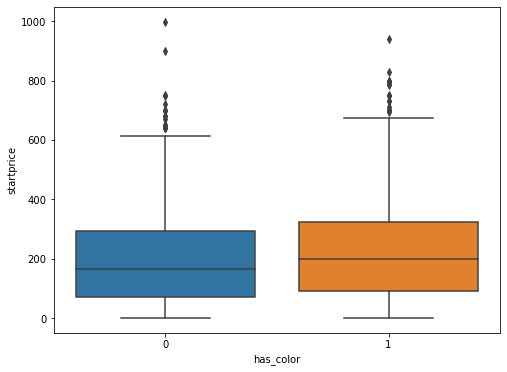

In [51]:
# color 변수가 결측치일 때와 결측치가 아닐 때, startprice는 유의미하게 변화할까?
# 그런 거 없음
data = pd.concat([df_cp['has_color'], df_cp['startprice']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='has_color', y="startprice", data=data)

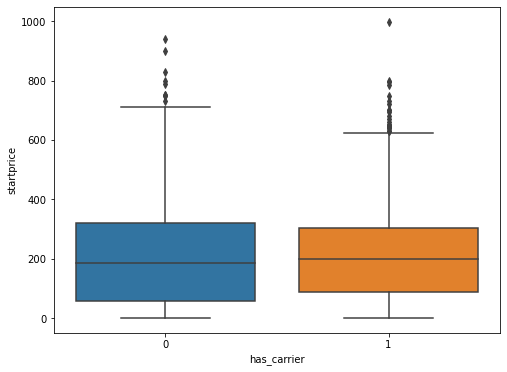

In [52]:
# carrier 변수가 결측치일 때와 결측치가 아닐 때, startprice는 유의미하게 변화할까?
# 그런 거 없음
data = pd.concat([df_cp['has_carrier'], df_cp['startprice']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='has_carrier', y="startprice", data=data)

# 데이터 전처리
비교를 위하여 두 가지 방법으로 데이터 전처리 진행

1. `color`, `carrier` 컬럼을 통째로 삭제
2. `color`, `carrier` 결측값을 `datawig`를 사용하여 채워넣기

In [61]:
for col in df.columns:
    if col not in ['startprice', 'charCountDescription', 'upperCaseDescription']:
        print(col, len(df[col].unique()), df[col].unique())

BuyItNow 2 [0 1]
carrier 5 ['None' nan 'AT&T' 'Sprint/T-Mobile' 'Verizon']
color 8 ['White' nan 'Space Gray' 'Midnight Black' 'Aura Black' 'Gold' 'Black'
 'Prism Black']
productline 8 ['Galaxy_S9' 'Galaxy_Note9' 'Unknown' 'Galaxy_S8' 'Galaxy_S7'
 'Galaxy_Note10' 'Galaxy_Note8' 'Galaxy_S10']
noDescription 2 ['contains description' 'no description']
sold 2 [1 0]


### 1번 데이터프레임 (기본)

In [83]:
y = df['sold']
X = df.loc[:, :"upperCaseDescription"]
X = X.drop(['carrier', 'color'], axis=1)

X = pd.concat([X, pd.get_dummies(X['productline'], prefix='productline')], axis=1)
X = X.drop('productline', axis=1)
X['noDescription'] = X['noDescription'].apply(lambda x: 1 if x == 'contains description' else 0)

X.head()

,BuyItNow,startprice,noDescription,charCountDescription,upperCaseDescription,productline_Galaxy_Note10,productline_Galaxy_Note8,productline_Galaxy_Note9,productline_Galaxy_S10,productline_Galaxy_S7,productline_Galaxy_S8,productline_Galaxy_S9,productline_Unknown
0,0,199.99,1,0,0,0,0,0,0,0,0,1,0
1,0,235.00,1,0,0,0,0,1,0,0,0,0,0
2,0,199.99,0,100,2,0,0,0,0,0,0,0,1
3,1,175.00,1,0,0,0,0,1,0,0,0,0,0
4,1,100.00,1,0,0,0,0,0,0,0,1,0,0


<AxesSubplot:>

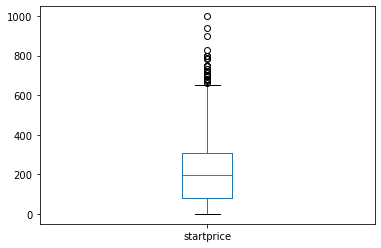

In [85]:
# 이상치 핸들링
X['startprice'].plot(kind='box')

In [98]:
# startprice >= 600인 경우(총 47개 샘플)의 80%가 최신기종(갤럭시 노트10)
# 이상치로 분류해서는 안 됨
print(len(X[X['startprice'] >= 600]))
print(X[X['startprice'] >= 600]['productline_Galaxy_Note10'].mean())

47
0.8085106382978723


### 2번 데이터프레임 (기본 + 결측값 채우기)

In [99]:
# y는 동일하므로 hard copy
y2 = y.copy()

In [101]:
X2 = df.loc[:, :"upperCaseDescription"]
#X = X.drop(['carrier', 'color'], axis=1) - 드롭하지 않음
X2 = pd.concat([X2, pd.get_dummies(X2['productline'], prefix='productline')], axis=1)
X2 = X2.drop('productline', axis=1)
X2['noDescription'] = X2['noDescription'].apply(lambda x: 1 if x == 'contains description' else 0)
X2.head()

,BuyItNow,startprice,carrier,color,noDescription,charCountDescription,upperCaseDescription,productline_Galaxy_Note10,productline_Galaxy_Note8,productline_Galaxy_Note9,productline_Galaxy_S10,productline_Galaxy_S7,productline_Galaxy_S8,productline_Galaxy_S9,productline_Unknown
0,0,199.99,None,White,1,0,0,0,0,0,0,0,0,1,0
1,0,235.00,None,NaN,1,0,0,0,0,1,0,0,0,0,0
2,0,199.99,NaN,NaN,0,100,2,0,0,0,0,0,0,0,1
3,1,175.00,AT&T,Space Gray,1,0,0,0,0,1,0,0,0,0,0
4,1,100.00,None,Space Gray,1,0,0,0,0,0,0,0,1,0,0


In [190]:
X2_with_label = pd.concat([X2, y2], axis=1)
X2_with_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 16 columns):
BuyItNow                     1485 non-null int64
startprice                   1485 non-null float64
carrier                      1179 non-null object
color                        892 non-null object
noDescription                1485 non-null int64
charCountDescription         1485 non-null int64
upperCaseDescription         1485 non-null int64
productline_Galaxy_Note10    1485 non-null uint8
productline_Galaxy_Note8     1485 non-null uint8
productline_Galaxy_Note9     1485 non-null uint8
productline_Galaxy_S10       1485 non-null uint8
productline_Galaxy_S7        1485 non-null uint8
productline_Galaxy_S8        1485 non-null uint8
productline_Galaxy_S9        1485 non-null uint8
productline_Unknown          1485 non-null uint8
sold                         1485 non-null int64
dtypes: float64(1), int64(5), object(2), uint8(8)
memory usage: 104.5+ KB


In [191]:
X2_with_label['carrier'].unique()

array(['None', nan, 'AT&T', 'Sprint/T-Mobile', 'Verizon'], dtype=object)

In [192]:
X2_with_label['carrier'].value_counts()

None               863
AT&T               177
Verizon             87
Sprint/T-Mobile     52
Name: carrier, dtype: int64

In [193]:
X2_with_label['BuyItNow'] = X2_with_label['BuyItNow'].astype(str)
X2_with_label['sold'] = X2_with_label['sold'].astype(str)
X2_with_label['carrier'] = X2_with_label['carrier'].map({'None':str(0),
                             'AT&T':str(1),
                             'Verizon':str(2),
                             'Sprint/T-Mobile':str(3)})

In [194]:
X2_train, X2_test = datawig.utils.random_split(X2_with_label,
                                              split_ratios=[0.8, 0.2])
X2_train = X2_train.reset_index(drop=True)
X2_test = X2_test.reset_index(drop=True)

In [131]:
# from datawig.column_encoders import CategoricalEncoder, NumericalEncoder
# from datawig.mxnet_input_symbols import EmbeddingFeaturizer, NumericalFeaturizer
# from datawig import Imputer

# #Using LSTMs instead of bag-of-words
# data_encoder_cols = [CategoricalEncoder('BuyItNow'), NumericalEncoder('startprice'),
#                     CategoricalEncoder('sold')]
# label_encoder_cols = [CategoricalEncoder('carrier')]
# data_featurizer_cols = [EmbeddingFeaturizer('BuyItNow'), NumericalFeaturizer('startprice'),
#                        EmbeddingFeaturizer('sold')]

# imputer = Imputer(
#     data_featurizers=data_featurizer_cols,
#     label_encoders=label_encoder_cols,
#     data_encoders=data_encoder_cols,
#     output_path='imputer_model'
# )
# imputer.fit(train_df=X2_train, test_split=0.19)
#imputed = imputer.predict(X2_test)

In [198]:
#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    # 결측치를 채우고자 하는 타깃 컬럼과 상관성이 존재하는 컬럼들
    input_columns=['BuyItNow','startprice','sold'],
    output_column= 'carrier', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

In [177]:
#Fit an imputer model on the train data
imputer.fit(train_df=X2_train)

#Impute missing values and return original dataframe with predictions
imputed = imputer.predict(X2_test)

imputer.predict(X2_train)

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [196]:
X2_with_label.head()

,BuyItNow,startprice,carrier,color,noDescription,charCountDescription,upperCaseDescription,productline_Galaxy_Note10,productline_Galaxy_Note8,productline_Galaxy_Note9,productline_Galaxy_S10,productline_Galaxy_S7,productline_Galaxy_S8,productline_Galaxy_S9,productline_Unknown,sold
0,0,199.99,0,White,1,0,0,0,0,0,0,0,0,1,0,1
1,0,235.00,0,NaN,1,0,0,0,0,1,0,0,0,0,0,0
2,0,199.99,NaN,NaN,0,100,2,0,0,0,0,0,0,0,1,0
3,1,175.00,1,Space Gray,1,0,0,0,0,1,0,0,0,0,0,1
4,1,100.00,0,Space Gray,1,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
X2_with_label_carrier_complete = imputer.complete(X2_with_label)
print('done')

In [168]:
complete_imputed

,BuyItNow,startprice,carrier,color,noDescription,charCountDescription,upperCaseDescription,productline_Galaxy_Note10,productline_Galaxy_Note8,productline_Galaxy_Note9,productline_Galaxy_S10,productline_Galaxy_S7,productline_Galaxy_S8,productline_Galaxy_S9,productline_Unknown,sold
0,1,700.00,nan,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0,110.00,0.0,Midnight Black,0.0,103.0,10.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0,300.00,0.0,White,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1,0.99,0.0,Midnight Black,0.0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0,339.99,3.0,Midnight Black,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,1,445.00,0.0,White,0.0,102.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1184,1,255.00,0.0,Midnight Black,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1185,0,730.00,nan,White,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1186,0,55.00,nan,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [170]:
complete_imputed['carrier'].value_counts()

0.0    698
nan    240
1.0    143
2.0     69
3.0     38
Name: carrier, dtype: int64

In [ ]:
print('h')

In [111]:
f1 = f1_score(imputed['carrier'], imputed['carrier_imputed'])

TypeError: '<' not supported between instances of 'float' and 'str'

In [105]:
imputed

,BuyItNow,startprice,carrier,color,noDescription,charCountDescription,upperCaseDescription,productline_Galaxy_Note10,productline_Galaxy_Note8,productline_Galaxy_Note9,productline_Galaxy_S10,productline_Galaxy_S7,productline_Galaxy_S8,productline_Galaxy_S9,productline_Unknown,sold,carrier_imputed,carrier_imputed_proba
1470,0,219.99,None,Midnight Black,0,100,4,0,1,0,0,0,0,0,0,0,None,0.705283
265,1,100.00,None,NaN,1,0,0,0,0,1,0,0,0,0,0,1,None,0.690257
320,1,179.00,NaN,Midnight Black,0,80,66,0,0,0,0,0,1,0,0,0,None,0.672498
560,0,319.00,Sprint/T-Mobile,Space Gray,1,0,0,1,0,0,0,0,0,0,0,0,None,0.601705
1428,0,509.00,AT&T,NaN,0,27,1,1,0,0,0,0,0,0,0,0,None,0.678429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,0,79.00,NaN,NaN,0,97,5,0,0,0,0,0,1,0,0,0,None,0.796423
1344,1,19.99,NaN,Space Gray,1,0,0,0,0,0,0,0,0,0,1,0,None,0.765276
527,0,387.45,None,Midnight Black,0,106,2,0,0,0,0,0,1,0,0,0,None,0.575909
1149,0,139.00,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,None,0.765047


In [127]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [128]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# y = np.array([1, 1, 1, 2, 2, 2])

eclf1 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
eclf1_pred = eclf1.predict(X_test)

np.array_equal(eclf1.named_estimators_.lr.predict(X_test),
                eclf1.named_estimators_['lr'].predict(X_test))

eclf2 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
         voting='soft')
eclf2 = eclf2.fit(X_train, y_train)
eclf2_pred = eclf2.predict(X_test)


eclf3 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
        voting='soft', weights=[2,1,1],
        flatten_transform=True)
eclf3 = eclf3.fit(X_train, y_train)
eclf3_pred = eclf3.predict(X_test)
print(eclf3.transform(X_test).shape)

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

(152, 6)


/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [129]:
accuracy_score(y_test, eclf1_pred)

0.75

In [130]:
accuracy_score(y_test, eclf2_pred)

0.7236842105263158

In [131]:
accuracy_score(y_test, eclf3_pred)

0.743421052631579

# RF

In [79]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[50, 100, 150],
    'criterion':['gini', 'entropy'],
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 16, 20],
                         'n_estimators': [50, 100, 150]})

In [80]:
grid_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 8,
 'min_samples_split': 20,
 'n_estimators': 50}

In [81]:
pred = grid_cv.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, pred)
accuracy

0.7811447811447811

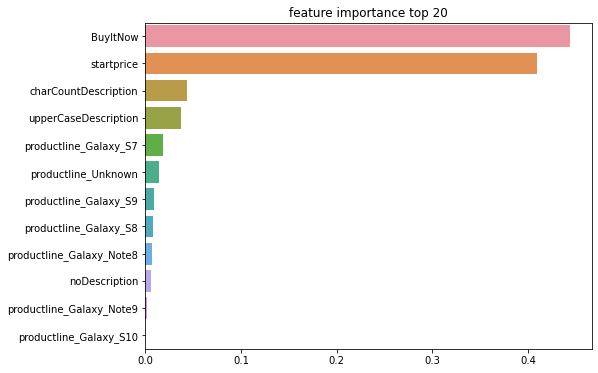

In [82]:
ftr_importances_values = grid_cv.best_estimator_.feature_importances_
ftr_importances_values = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top20 = ftr_importances_values.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('feature importance top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [83]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_accuracy

CPU times: user 149 ms, sys: 10.3 ms, total: 160 ms
Wall time: 186 ms


0.797979797979798

In [85]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy',
                               max_depth=12,
                               min_samples_leaf=8,
                               min_samples_split=8,
                               #n_estimators=150,
                               random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
accuracy_score(y_test, y_pred_dt)

0.7878787878787878